In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
#Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [2]:
#Read azdias data
azdias = pd.read_csv("/content/drive/MyDrive/Arvato_Data/azdias")
azdias.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,NaN,NaN,5.0,1.0,4.0,1.0,6,3,6,6,7,3,5,5,5,4,7,2,3,1,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,0.0,0.0,2.0,12.0,0.0,3.0,6.0,8A,8.0,51.0,5.0,1.0,5.0,5.0,2.0,3.0,1.0,1.0,0,0,10,0,0,0,10,10,NaN,0,0,0,...,3.0,4.0,1.0,5.0,3.0,5.0,7,2,4,4,4,3,2,3,7,6,4,5,6,1,3,1.0,2.0,0.0,3.0,3.0,1.0,0.0,2,0.0,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,0.0,0.0,1.0,7.0,0.0,3.0,2.0,4C,4.0,24.0,3.0,2.0,4.0,4.0,1.0,3.0,2.0,2.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,2.0,2.0,3.0,5.0,4.0,5.0,7,6,1,7,7,3,4,3,3,4,3,4,3,4,2,0.0,3.0,0.0,2.0,5.0,0.0,1.0,1,0.0,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,0.0,2.0,0.0,2.0,4.0,2A,2.0,12.0,2.0,3.0,2.0,2.0,4.0,4.0,5.0,3.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,0.0,3.0,2.0,3.0,2.0,3.0,4,7,1,5,4,4,4,1,4,3,2,5,4,4,1,0.0,1.0,0.0,4.0,5.0,0.0,0.0,1,1.0,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,0.0,0.0,4.0,3.0,0.0,4.0,2.0,6B,6.0,43.0,5.0,3.0,3.0,3.0,3.0,4.0,3.0,3.0,3,5,5,1,2,0,10,5,10.0,6,6,1,...,5.0,5.0,5.0,3.0,5.0,5.0,2,4,4,2,3,6,4,2,4,2,4,6,2,7,2,0.0,3.0,0.0,4.0,3.0,0.0,1.0,2,0.0,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [3]:
#Read customer data
customers = pd.read_csv("/content/drive/MyDrive/Arvato_Data/customers")
customers.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (18,19) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,0.0,0.0,2.0,1.0,0.0,1.0,3.0,1A,1.0,13.0,5.0,4.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,3.0,1,3,5,1,3,4,7,6,2,1,2,6,1,6,3,0.0,3.0,0.0,4.0,4.0,0.0,8.0,1,0.0,3.0,5.0,3.0,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,3.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,1,6,0,5,0,10,10,0.0,6,0,0,...,NaN,NaN,NaN,3,3,6,2,3,4,5,6,4,1,2,3,1,7,3,0.0,NaN,0.0,NaN,NaN,0.0,NaN,1,0.0,NaN,6.0,6.0,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,7.0,5D,5.0,34.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,1.0,5,7,2,6,7,1,7,3,4,2,1,2,1,3,1,0.0,3.0,0.0,1.0,5.0,0.0,0.0,2,0.0,4.0,10.0,13.0,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,NaN,0.0,0.0,1.0,0.0,1.0,7.0,4C,4.0,24.0,2.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,1.0,5.0,2.0,3,3,5,3,3,4,5,4,3,3,3,6,4,7,0,0.0,1.0,0.0,3.0,4.0,0.0,0.0,1,0.0,2.0,6.0,4.0,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,0.0,0.0,4.0,7.0,0.0,3.0,3.0,7B,7.0,41.0,6.0,4.0,3.0,3.0,3.0,4.0,3.0,3.0,1,2,3,5,0,3,10,7,0.0,0,0,6,...,4.0,3.0,5.0,5,4,5,2,3,5,6,6,5,5,4,4,4,5,1,0.0,3.0,0.0,2.0,4.0,0.0,1.0,2,0.0,4.0,3.0,5.0,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


There is some warning regarding the Columns (18, 19). Apparently datatype is mixed in the column. We'll take care of it in sometime. 

We were also provided with two other datasets: 
1. Attrubutes Value (DIAS Attributes - Values) : It explains the values in each attribute column above.
2. Attributes Info (DIAS Information Levels): It provides a brief explanation of each attributes column in our main dataset.

 Let's take a look.

In [4]:
Attributes_info = pd.read_excel("/content/drive/MyDrive/Arvato_Data/DIAS Information Levels - Attributes 2017.xlsx", header = 1)
Attributes_info.drop('Unnamed: 0', axis = 1, inplace = True)

In [5]:
Attributes_info.head()

,Information level,Attribute,Description,Additional notes
0,NaN,AGER_TYP,best-ager typology,in cooperation with Kantar TNS; the informatio...
1,Person,ALTERSKATEGORIE_GROB,age through prename analysis,modelled on millions of first name-age-referen...
2,NaN,ANREDE_KZ,gender,NaN
3,NaN,CJT_GESAMTTYP,Customer-Journey-Typology relating to the pref...,"relating to the preferred information, marketi..."
4,NaN,FINANZ_MINIMALIST,financial typology: low financial interest,Gfk-Typology based on a representative househo...


In [38]:
Attributes_Values = pd.read_excel("/content/drive/MyDrive/Arvato_Data/DIAS Attributes - Values 2017.xlsx", header = 1)
Attributes_Values.drop('Unnamed: 0', axis = 1, inplace = True)

In [39]:
Attributes_Values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,NaN,NaN,0,no classification possible
2,NaN,NaN,1,passive elderly
3,NaN,NaN,2,cultural elderly
4,NaN,NaN,3,experience-driven elderly


We will apply Forward-Fill method to fill the NaN values in the Attribute column above. 

In [40]:
Attributes_Values = Attributes_Values.ffill(axis = 0)
Attributes_Values.head()

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
1,AGER_TYP,best-ager typology,0,no classification possible
2,AGER_TYP,best-ager typology,1,passive elderly
3,AGER_TYP,best-ager typology,2,cultural elderly
4,AGER_TYP,best-ager typology,3,experience-driven elderly


**Let's take care of our warning columns first.**

In [9]:
Warning_df = customers[customers.columns[18:20]]
Warning_df.head()

,CAMEO_DEUG_2015,CAMEO_INTL_2015
0,1.0,13.0
1,NaN,NaN
2,5.0,34.0
3,4.0,24.0
4,7.0,41.0


Taking a look at the Attributes Values or these two columns:

In [10]:
Attributes_Values[Attributes_Values['Attribute'] == 'CAMEO_DEUG_2015']

,Attribute,Description,Value,Meaning
51,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,-1,unknown
52,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,1,upper class
53,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,2,upper middleclass
54,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,3,established middleclasse
55,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,4,consumption-oriented middleclass
56,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,5,active middleclass
57,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,6,low-consumption middleclass
58,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,7,lower middleclass
59,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,8,working class
60,CAMEO_DEUG_2015,CAMEO classification 2015 - Uppergroup,9,urban working class


In [11]:
#Similarly for CAMEO_INTL_2015, in our Attributes file CAMEO_INTL_2015 is defined as CAMEO_DEUINTL_2015

In [12]:
Attributes_Values[Attributes_Values['Attribute'] == 'CAMEO_DEUINTL_2015'].head()

,Attribute,Description,Value,Meaning
105,CAMEO_DEUINTL_2015,CAMEO classification 2015 - international typo...,-1,unknown
106,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,11,Wealthy Households-Pre-Family Couples & Singles
107,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,12,Wealthy Households-Young Couples With Children
108,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,13,Wealthy Households-Families With School Age Ch...
109,CAMEO_DEUINTL_2015,(each German CAMEO code belongs to one interna...,14,Wealthy Households-Older Families & Mature Co...


Both the above columns suggest the class segregation based on the wealth for the customers.
We need to first undrstand the uniques values in our customers dataset and then map the proper values accordingly.

In [13]:
Warning_df['CAMEO_DEUG_2015'].unique()

array([1.0, nan, 5.0, 4.0, 7.0, 3.0, 9.0, 2.0, 6.0, 8.0, '6', '3', '8',
       '9', '2', '4', '1', '7', '5', 'X'], dtype=object)

In [14]:
Warning_df['CAMEO_INTL_2015'].unique()

array([13.0, nan, 34.0, 24.0, 41.0, 23.0, 15.0, 55.0, 14.0, 22.0, 43.0,
       51.0, 33.0, 25.0, 44.0, 54.0, 32.0, 12.0, 35.0, 31.0, 45.0, 52.0,
       '45', '25', '55', '51', '14', '54', '43', '22', '15', '24', '35',
       '23', '12', '44', '41', '52', '31', '13', '34', '32', '33', 'XX'],
      dtype=object)

As can be seen from above there are some values denoted as 'X' or 'XX' which can be asigned to Null Values. We also need to change the datatype from mixed to Float.

In [31]:
def clear_warning(df):
  '''This function will replace the X and XX values from the warning columns of 
  the dataframe to NaN values'''
  
  warning_cols = df.columns[18:20].tolist()
  for col in warning_cols:
    df[col] = df[col].replace({'X': np.nan, 'XX': np.nan})
    df[col] = df[col].astype(float)

  return df

In [16]:
azdias = clear_warning(azdias)

In [17]:
customers = clear_warning(customers)

## Exploratory Data Analysis

Let's explore our customer's data and its attributes to get the information about our customers. 

We will mostly try to understand the Age, Gender, Income Levels etc. 

**Customer's Age Distribution**

In [18]:
cust_age_count = customers.groupby('ALTERSKATEGORIE_GROB')['LNR'].count()
cust_age_values = [0]
for v in cust_age_count.values:
  cust_age_values.append(v)

In [19]:
attri_age = Attributes_Values[Attributes_Values['Attribute'] == 'ALTERSKATEGORIE_GROB'][['Value', 'Meaning']]
attri_age['count'] = cust_age_values

(array([0, 1, 2, 3, 4, 5]), <a list of 6 Text major ticklabel objects>)

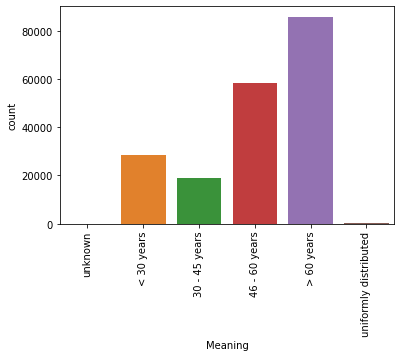

In [20]:
sns.barplot(x = 'Meaning', y = 'count', data = attri_age)
plt.xticks(rotation = 90)

**Customer's Gender**

In [21]:
cust_gender_count = customers.groupby('ANREDE_KZ')['LNR'].count()
cust_gender_values = [0]
for v in cust_gender_count.values:
  cust_gender_values.append(v)

In [22]:
attri_gender = Attributes_Values[Attributes_Values['Attribute'] == 'ANREDE_KZ'][['Value', 'Meaning']]
attri_gender['count'] = cust_gender_values

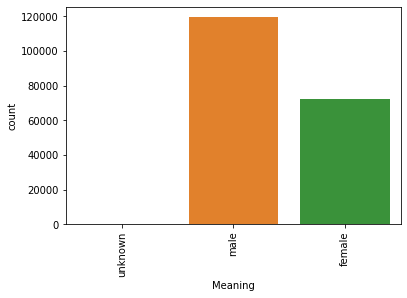

In [24]:
sns.barplot(x = 'Meaning', y = 'count', data = attri_gender)
plt.xticks(rotation = 90);

**Customer's Wealth Status Distribution**

In [25]:
cust_wealth_count = customers.groupby('CAMEO_DEUG_2015')['LNR'].count()
cust_wealth_values = [0]
for v in cust_wealth_count.values:
  cust_wealth_values.append(v)

In [26]:
attri_wealth = Attributes_Values[Attributes_Values['Attribute'] == 'CAMEO_DEUG_2015'][['Value', 'Meaning']]
attri_wealth['count'] = cust_wealth_values

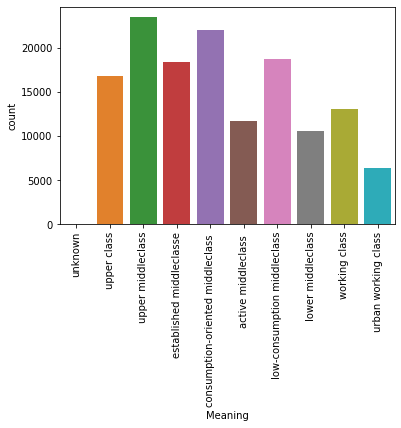

In [27]:
sns.barplot(x = 'Meaning', y = 'count', data = attri_wealth)
plt.xticks(rotation = 90);

First, we will look at the number of columns with object datatype. 

In [32]:
azdias.select_dtypes('object')

,CAMEO_DEU_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN
1,8A,NaN,1992-02-10 00:00:00,W
2,4C,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...
99995,4A,D19_TELKO_REST,1992-02-10 00:00:00,W
99996,7B,D19_UNBEKANNT,1996-03-29 00:00:00,W
99997,5C,D19_UNBEKANNT,2005-12-16 00:00:00,W
99998,7D,D19_BEKLEIDUNG_REST,1992-02-12 00:00:00,W


We can drop the column D19_LETZTER_KAUF_BRANCHE as it is just last transaction branch.
Also clumn EINGEFUEGT should be a datetime column. We will change it into Datetime and extract year from it. 

In [32]:
def drop_d19letzter(df):
  '''Dropping the D19_LETZTER_KAUF_BRANCHE column from the dataset''' 

  df = df.drop('D19_LETZTER_KAUF_BRANCHE', axis = 1)
  
  return df

In [30]:
azdias = drop_d19letzter(azdias)

In [33]:
def fix_ein(df):
  '''Coverting the EINGEFUEGT_AM column from object datatype to Datetime
  and extracting the year'''

  df['EINGEFUEGT_AM'] = pd.to_datetime(df['EINGEFUEGT_AM'])
  df['EINGEFUEGT_AM'] = df['EINGEFUEGT_AM'].dt.year

  return df

In [32]:
azdias = fix_ein(azdias)

We will encode OST_WEST_KZ and CAMEO_DEU_2015 columns to proper integer. OST_WEST_KZ is a categorical column so we mapped 0,1 in place of W, O. Also, CAMEO_DEU_2015 has values not useful for our analysis, so we mapped each unique values to an integer.

In [33]:
azdias['OST_WEST_KZ'].unique()

array([nan, 'W', 'O'], dtype=object)

In [34]:
Attributes_Values[Attributes_Values['Attribute'] == 'OST_WEST_KZ']

,Attribute,Description,Value,Meaning
2013,OST_WEST_KZ,flag indicating the former GDR/FRG,-1,unknown
2014,OST_WEST_KZ,flag indicating the former GDR/FRG,O,East (GDR)
2015,OST_WEST_KZ,flag indicating the former GDR/FRG,W,West (FRG)


In [34]:
def encode_ost(df):
  '''Replacing the values of the OST_WEST_KZ column from O,W to 1, 0 
  respectively'''

  df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace({'O': 1, 'W': 0})

  return df

In [36]:
azdias = encode_ost(azdias)

In [35]:
def cam_fix(df):
  '''Replacing the values of CAMEO_DEU_2015 to proper integers'''
  
  cam_list = df['CAMEO_DEU_2015'].sort_values().unique().tolist()
  for key, value in enumerate(cam_list):
    df['CAMEO_DEU_2015'] = df['CAMEO_DEU_2015'].replace({value : key})

  return df

In [38]:
azdias = cam_fix(azdias)

 Columns LP_STATUS_GROB has grouped LP_STATUS_FEIN values, which can be dropped as the information is already covered in LP_STATUS_FEIN.
 Similar is the case with LP_FAMILIE_GROB as it has grouped LP_FAMILIE_FEIN values.
 Further, LP_LEBENSPHASE_GROB has grouped the information of lifestage which was covered in detail in LP_LEBENSPHASE_FEIN.

 So, now dropping the three columns.

In [36]:
def drop_LP(df):
  
  '''Dropping all the LP_GROB columns'''

  df.drop(['LP_STATUS_GROB', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_GROB'], axis = 1, inplace = True)

  return df

In [40]:
azdias = drop_LP(azdias)

Some of the columns contains 0, -1 or 9 as a value for unknown. All these unknown values can be replace with NaN.

In [41]:
unknown_attri_values = Attributes_Values[Attributes_Values['Meaning'] == 'unknown']
unknown_attri_values.head(5)

,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,-1,unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"-1, 0",unknown
33,ANREDE_KZ,gender,"-1, 0",unknown
40,BALLRAUM,distance to next urban centre,-1,unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,-1,unknown


In [42]:
unknown_attri_values['Value'] = unknown_attri_values['Value'].astype(str).str.split(",")
unknown_attri_values.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Attribute,Description,Value,Meaning
0,AGER_TYP,best-ager typology,[-1],unknown
5,ALTERSKATEGORIE_GROB,age classification through prename analysis,"[-1, 0]",unknown
33,ANREDE_KZ,gender,"[-1, 0]",unknown
40,BALLRAUM,distance to next urban centre,[-1],unknown
48,BIP_FLAG,business-flag indicating companies in the buil...,[-1],unknown


In [43]:
#Creating a function to return the different unknown values per attribute in a iterable format
def flat_value(my_list, datatype=(int, float)):
  
    flat_list = [] #This list will hold the string values with whitespace in the left
    for item in my_list:
        if isinstance(item, datatype):
            flat_list.extend(item)

    unknown = [] #We will remove the whitespace and convert it to int
    for values in flat_list:
        value = int(values.lstrip())
        unknown.append(value)
    unknown = list(set(unknown)) #to contain only unique values
    return unknown

def get_unknown(attribute, unknown_attri_values):
    
    my_list = unknown_attri_values[unknown_attri_values['Attribute'] == attribute]['Value'].values
    unknown = flat_value(my_list)
    
    return unknown

In [44]:
#Creating a function to convert the unknown values from the dataset with NaN

def replace_with_nan(data):
    '''Replacing the unknown values to NaN values'''
    try:
        if data in unknown:
            return np.nan
        else:
            return data
    except:
        return data

In [45]:
#Replacing all the unknown values in the dataset to NaN values
def replace_unknown(df, unknown_attri_values):
    """
    Replaces unknown values to 'np.nan' in all the columns common to both unkown_attri_values 
    as well as our dataset.
    """
    for attribute in unknown_attri_values.Attribute:
        unknown = get_unknown(attribute, unknown_attri_values)
        if attribute in df.columns:
            df[attribute] = df[attribute].apply(replace_with_nan)
    return df

In [46]:
azdias = replace_unknown(azdias, unknown_attri_values)

We can remove LNR column as it contains ID of customer which is not required in Data Preprocessing part.

In [46]:
def drop_LNR(df):
  '''Dropping the LNR column'''
  
  df = df.drop('LNR', axis = 1)

  return df

In [48]:
azdias = drop_LNR(azdias)

After encoding all the columns with proper values now we can look for the null values and try to clean the data. 

Our objective will be to remove those columns with more than 40% of data as null. Also, to remove those rows with more than 50 columns as null. 

For the remaining data after cleaning we will impute null values using SimpleImputer as the data is demographic, so it make sense to Impute the data with most frequent values. 

First let's look at the null values columnwise.

In [57]:
percent_null_col = azdias.isnull().sum().sort_values(ascending = False) * 100 / len(azdias)

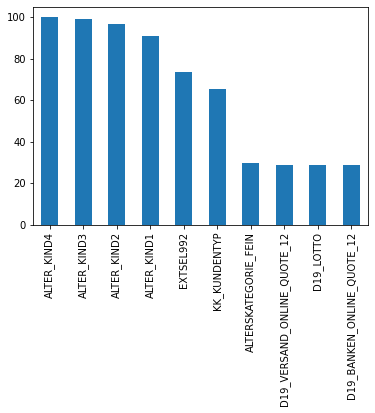

In [58]:
percent_null_col.head(10).plot(kind = 'bar')
plt.xticks(rotation = 90);

So, we can see we have 6 columns in our dataset which has more than 40% of the data as null values. These columns will not be of much use and can be dropped from our dataset.

In [49]:
def drop_null_col(df):
  '''Dropping the columns with null values more than 40%'''

  percent_null_col = df.isnull().sum().sort_values(ascending = False) * 100 / len(df)
  cols_to_drop = percent_null_col[percent_null_col > 40].index
  cols_to_drop = cols_to_drop.tolist()

  df = df.drop(cols_to_drop, axis = 1)

  return df

In [50]:
azdias = drop_null_col(azdias)

Now we will take care of null values row-wise.

In [64]:
null_row = azdias.isnull().sum(axis = 1).sort_values(ascending = False)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


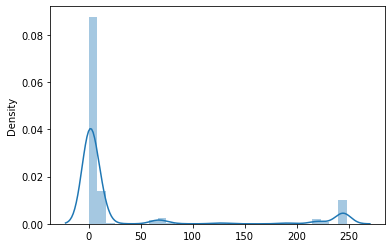

In [65]:
sns.distplot(null_row, bins = 30)

In [51]:
def drop_rows(df):

  df = df.dropna(thresh = df.shape[1] - 50) #dropping the rows with threshold more than 50

  df = df.reset_index(drop = True)

  return df

In [52]:
azdias = drop_rows(azdias)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


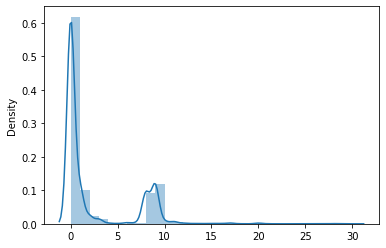

In [68]:
null_row_1 = azdias.isnull().sum(axis = 1).sort_values(ascending = False)
sns.distplot(null_row_1, bins = 30)

Let's create a function to clean full dataset as done above for azdias_test. We will apply this function to both azdias as well as customer dataset.

In [61]:
import time
def clean_data(df, unknown_attri_values):
  '''
  Cleaning the dataset by applying all the function above on the customers dataset.
  
  input: 
  df: a dataframe for cleaning
  unknown_attri_values: Attributes Values dataframe with only unknown values for each Attributes.

  oputput: 
  df: Cleaned dataframe.
  '''
  start = time.time()

  print("Cleaning the Dataframe")
  # Fixing columns 18 and 19
  
  print("\tFixing 18 and 19 columns")

  df = clear_warning(df)

  print("\tFixing CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM, OST_WEST_KZ, LP_GROB")
  df = drop_d19letzter(df)

  df = fix_ein(df)

  df = encode_ost(df)

  df = cam_fix(df)

  df = drop_LP(df)

  print ("\tFixing unknown values in the columns")
  df = replace_unknown(df, unknown_attri_values)

  print ("\tDropping LNR ID")
  df = drop_LNR(df)

  print ("\tFixing Null Values Column-wise and row-wise")

  df = drop_null_col(df)

  df = drop_rows(df)

  end = time.time()

  print(f'Cleaning done in {end-start} seconds')

  return df

In [55]:
azdias.to_csv('azdias_cleaned', index = False)

In [54]:
customers = clean_data(customers, unknown_attri_values)
customers.to_csv('customers_cleaned', index = False)

From here on we will use cleaned dataset to save Run-time memory.

Now we can Impute the remaining Null values as discussed before.

In [2]:
azdias_new = pd.read_csv('/content/azdias_cleaned')

In [3]:
customers_new = pd.read_csv('/content/customers_cleaned')

In [4]:
imputer = SimpleImputer(strategy = 'most_frequent')

In [5]:
azdias = pd.DataFrame(imputer.fit_transform(azdias_new), columns = azdias_new.columns) #fit and transform the Population data

In [6]:
#Let's dorp the extra columns from the customers as they are not required for analysis.

Extra_columns = []
for col in customers_new.columns:
    if col in azdias_new.columns:
        pass
    else:
        Extra_columns.append(col)
customer_extra_cols = customers_new[Extra_columns].copy()
customers_new = customers_new.drop(Extra_columns, axis = 1)

In [7]:
# we will only transform the customers to avoid over-fitting
customers = pd.DataFrame(imputer.transform(customers_new), columns = customers_new.columns)

Now that we have taken care of our Null Values in the data, we will now scale the datasets so that all the values remain in the same range. We will use StandardScaler function from Sklearn library.

In [8]:
scaler = StandardScaler()

In [9]:
azdias = pd.DataFrame(scaler.fit_transform(azdias), columns = azdias.columns)
customers = pd.DataFrame(scaler.transform(customers), columns = customers.columns)

# **Customer Segmentation Report**



We can see that we have too many features for performing analysis. However not all features are important. To choose the important features, we can try dimensionality reduction technique using PCA


In [10]:
import time
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import GridSearchCV


from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score

In [11]:
pca = PCA() #Initialise PCA

In [12]:
azdias_pca = pca.fit(azdias) #Fitting our data to PCA

In [13]:
azdias_pca.explained_variance_ratio_[0:11]#Top 10 features nearly explains 36% of the data

array([0.08226723, 0.07345675, 0.05101433, 0.04601791, 0.03873149,
       0.02285697, 0.01985992, 0.01694369, 0.01541186, 0.01387255,
       0.01226451])

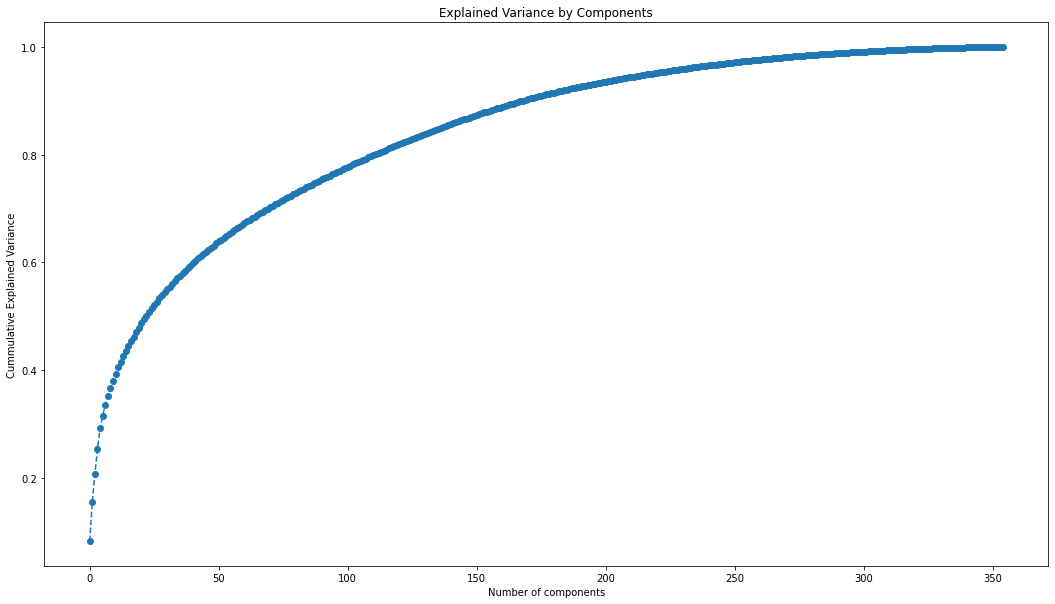

In [14]:
#Let's try to find the number of essential features using the PCA plot of ratio of Variance and number of features
#Plot to find the optimal number of features which will explain atleast 80% of our data
plt.figure(figsize = (18, 10))
plt.plot(range(len(azdias.columns)), azdias_pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--' )
plt.xlabel('Number of components')
plt.ylabel('Cummulative Explained Variance')
plt.title('Explained Variance by Components')
plt.show()

From the graph we observe that 120 components are enough to explain 80% variability in the data.

In [15]:
pca_120 = PCA(n_components = 120) #We will choose 120 as number of components

In [16]:
pca_120.fit(azdias)
azdias_pca_120 = pca_120.transform(azdias)

Let's now run KMeans for specifying the clusters in which we group our data

In [17]:
#Let's start with determining the number of clusters needed
wcss = []  #Empty list of sum of squared distance of data points within each cluster
for i in range(2, 22, 2): #running the loop ten times to find the optimal number of clusters
  kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 101) #k-means++ will initialize a seed for cluster centroid 
  kmeans.fit(azdias_pca_120)
  wcss.append(kmeans.inertia_) #kmeans.inertia_ will provide the sum of squared distance of each data component from the cluster centroid

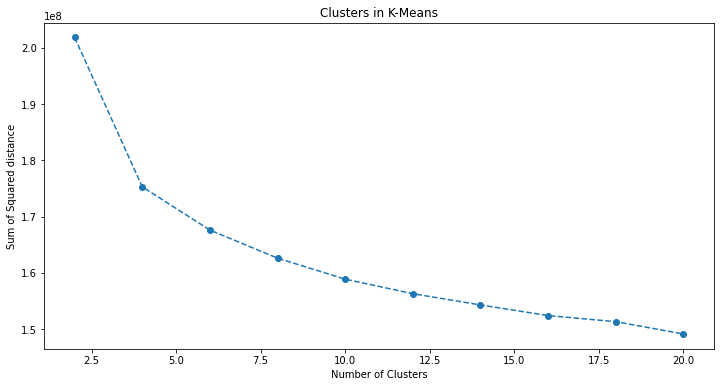

In [18]:
#The next step involves plotting the WCSS against the number of components on a graph. 
plt.figure(figsize = (12, 6))
plt.plot(range(2, 22, 2), wcss, marker = 'o', linestyle = '--')
plt.title('Clusters in K-Means')
plt.xlabel('Number of Clusters')
plt.ylabel('Sum of Squared distance')
plt.show()



Now to choose the number of optimal clusters, we deployed the Elbow Method by plotting the wcss over the defined range of clusters above. The main idea is to choose the cluster value in such a way that beyond it, the decrease in the Sum of Squared distance is only marginal and will not have a bigger impact in our analysis. However, the choice is subjective and there is no correct answer for it.

Looking at above we can observe that anything between 7-10 clusters are enough to segment our data in most optimal way. We will choose 8 Clusters for our analysis.

All we needed to do now is to implement the number of clusters in our algorithm


In [19]:
kmeans_pca = KMeans(n_clusters = 8, init = 'k-means++', random_state = 101)

In [20]:
kmeans_pca.fit(azdias_pca_120)
azdias_clusters = kmeans_pca.predict(azdias_pca_120)

In [21]:
customers_pca_120 = pca_120.transform(customers) #Running the PCA and KMEans on customers dataset based on the findings above

In [22]:
customers_clusters = kmeans_pca.predict(customers_pca_120)

In [23]:
#Creating a dataframe for the number of clusters 
#for doing comparative analysis of customers with Population
azdias_clusters = pd.Series(azdias_clusters)
customers_clusters = pd.Series(customers_clusters)

cluster = pd.DataFrame([])

cluster['population_count'] = azdias_clusters.value_counts().sort_index()
cluster['customers_count'] = customers_clusters.value_counts().sort_index()
cluster.reset_index(inplace=True)
cluster.rename(columns = {'index':'cluster_no'}, inplace = True)
cluster.head()

,cluster_no,population_count,customers_count
0,0,136671,35179
1,1,107352,16564
2,2,125250,41579
3,3,74998,32999
4,4,122860,1454


Let's find the ratio of customers to the general population cluster-wise

Text(0.5, 1.0, 'Percetage of customers to population cluster-wise')

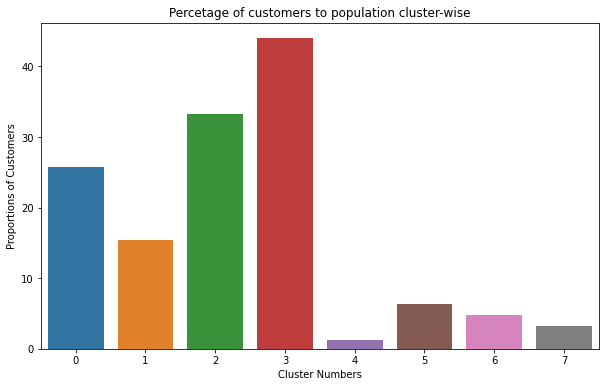

In [25]:
cluster['cust_to_pop'] = cluster['customers_count'] * 100 / cluster['population_count']

plt.figure(figsize = (10, 6))
sns.barplot(x = 'cluster_no', y = 'cust_to_pop', data = cluster)
plt.xlabel("Cluster Numbers")
plt.ylabel("Proportions of Customers")
plt.title('Percetage of customers to population cluster-wise')

Now we'll look at the proportions of customers and population in each cluster individually to better understand the cluster distribution

Text(0.5, 1.0, 'Percetage of customers cluster-wise')

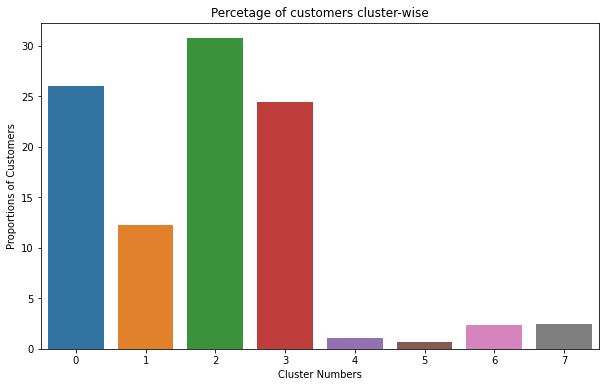

In [26]:
cluster['cust_per_clust'] = cluster['customers_count'] * 100 / cluster['customers_count'].sum()

plt.figure(figsize = (10, 6))
sns.barplot(x = 'cluster_no', y = 'cust_per_clust', data = cluster)
plt.xlabel("Cluster Numbers")
plt.ylabel("Proportions of Customers")
plt.title('Percetage of customers cluster-wise')

From above we can see that majority of the customers are lying in Clusters - 0, 2, 3 Whereas cluster 4 and 5 are most under-represented.

Text(0.5, 1.0, 'Percetage of Population cluster-wise')

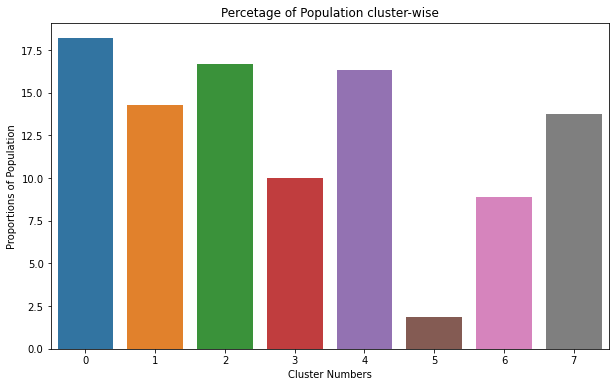

In [27]:
cluster['pop_per_clust'] = cluster['population_count'] * 100 / cluster['population_count'].sum()

plt.figure(figsize = (10, 6))
sns.barplot(x = 'cluster_no', y = 'pop_per_clust', data = cluster)
plt.xlabel("Cluster Numbers")
plt.ylabel("Proportions of Population")
plt.title('Percetage of Population cluster-wise')

Compared to Customers, Population in each clusters are more uniformly distributed barring cluster 5 which is under-represented.

# **Supervised Learning Model**

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [29]:
#read the training dataset
#Due to Unnamed: 0 column, columns are shifted to 1 place right. We will drop the column and clean our data as above
mailout_train = pd.read_csv('/content/drive/MyDrive/Arvato_Data/Udacity_MAILOUT_052018_TRAIN.csv') 
mailout_train = mailout_train.drop('Unnamed: 0', axis = 1)
mailout_train.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,NaN,NaN,NaN,NaN,8.0,15.0,0.0,0.0,1.0,13.0,0.0,3.0,5.0,5D,5.0,34.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,5.0,2.0,5.0,1.0,6,7,2,6,6,1,7,1,3,2,1,5,1,3,3,0.0,3.0,0.0,2.0,4.0,0.0,4.0,2,1.0,2.0,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,2.0,1.0,0.0,2.0,5.0,5B,5.0,32.0,2.0,2.0,2.0,2.0,4.0,3.0,5.0,4.0,1,1,5,0,0,3,10,10,0.0,0,0,6,...,1.0,2.0,3.0,1.0,3.0,6,6,1,5,6,3,6,5,5,4,3,1,3,4,2,0.0,1.0,0.0,2.0,5.0,0.0,0.0,1,1.0,3.0,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1776,1,1.0,9.0,NaN,NaN,NaN,NaN,7.0,0.0,NaN,0.0,0.0,1.0,0.0,4.0,1.0,2D,2.0,14.0,4.0,5.0,1.0,1.0,5.0,5.0,5.0,5.0,0,1,7,0,0,0,10,7,0.0,5,0,0,...,4.0,3.0,1.0,5.0,2.0,3,3,4,1,3,4,7,6,1,1,5,3,1,7,3,0.0,3.0,0.0,1.0,5.0,0.0,10.0,1,4.0,1.0,6.0,4.0,2.0,NaN,9.0,2.0,3,0,1,4
3,1460,2,1.0,6.0,NaN,NaN,NaN,NaN,6.0,4.0,0.0,0.0,2.0,4.0,0.0,4.0,2.0,2D,2.0,14.0,2.0,5.0,2.0,2.0,5.0,5.0,5.0,4.0,0,0,10,0,0,0,10,10,0.0,0,0,6,...,3.0,5.0,2.0,5.0,1.0,5,7,1,6,7,1,7,1,4,2,2,5,3,2,1,0.0,3.0,0.0,3.0,5.0,0.0,5.0,2,1.0,4.0,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
4,1783,2,1.0,9.0,NaN,NaN,NaN,NaN,9.0,53.0,0.0,0.0,1.0,44.0,0.0,3.0,4.0,7B,7.0,41.0,6.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,5,0,...,3.0,5.0,1.0,5.0,1.0,5,4,6,2,5,5,6,6,4,5,4,6,2,7,1,0.0,3.0,0.0,2.0,5.0,0.0,4.0,1,0.0,4.0,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3


In [30]:
Target = mailout_train["RESPONSE"]
mailout_train_LNR = mailout_train["LNR"]

In [47]:
#Let's clean the data. We will use the function from above however, we will not drop the missing values. 
#Rewriting the function from above.
def clean_data(df, unknown_attri_values):
  '''
  Cleaning the dataset by applying all the function above on the customers dataset.
  
  input: 
  df: a dataframe for cleaning
  unknown_attri_values: Attributes Values dataframe with only unknown values for each Attributes.

  oputput: 
  df: Cleaned dataframe.
  '''
  start = time.time()

  print("Cleaning the Dataframe")
  # Fixing columns 18 and 19
  
  print("\tFixing 18 and 19 columns")

  df = clear_warning(df)

  print("\tFixing CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM, OST_WEST_KZ, LP_GROB")
  df = drop_d19letzter(df)

  df = fix_ein(df)

  df = encode_ost(df)

  df = cam_fix(df)

  df = drop_LP(df)

  print ("\tFixing unknown values in the columns")
  df = replace_unknown(df, unknown_attri_values)

  print ("\tDropping LNR ID")
  df = drop_LNR(df)

  end = time.time()

  print(f'Cleaning done in {end-start} seconds')

  return df


In [49]:
mailout_train = clean_data(mailout_train, unknown_attri_values)

Cleaning the Dataframe
	Fixing 18 and 19 columns
	Fixing CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM, OST_WEST_KZ, LP_GROB
	Fixing unknown values in the columns
	Dropping LNR ID
	Fixing Null Values Column-wise and row-wise
Cleaning done in 6.9313805103302 seconds


In [52]:
ext_col = [] #deleting the extra columns
for col in mailout_train.columns:
  if col in azdias.columns:
    pass
  else:
    ext_col.append(col)
print (ext_col)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP', 'RESPONSE']


In [53]:
mailout_train = mailout_train.drop(ext_col, axis = 1)

In [55]:
print(mailout_train.shape)
print(azdias.shape)

(42962, 355)
(751331, 355)


In [59]:
#Imputing NaN values
mailout_train = pd.DataFrame(imputer.fit_transform(mailout_train), columns = mailout_train.columns)

In [60]:
#Scaling our data
mailout_train = pd.DataFrame(scaler.fit_transform(mailout_train), columns = mailout_train.columns)

We will first train the model with Logistic regression and then setting it as a benchmark performance we'll try different algorithm to improve our model.

In [62]:
#Splitting the dataset in Train and Test dataset
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(mailout_train, Target, test_size=0.30, random_state = 101)

In [63]:
lr = LogisticRegression(random_state = 101) #Initialize the Logistic regression model

In [64]:
lr.fit(X_train, y_train) #fitting the model.

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=101)

Some people use predict() after creating a logistic regression model. Sklearn's function predict() only returns 0's and 1's. In this competition, the metric is AUC. You will score a higher AUC if you submit probabilities like 0.2, 0.6, 0.8, etc. Therefore after building your logistic regression model (or whatever model), use predict_proba()[:,1] which returns probabilities.

In [65]:
pred = lr.predict_proba(X_val)[:, 1]
print ("LR ROC-AUC Score: ", roc_auc_score(y_val, pred))

LR ROC-AUC Score:  0.6435904737367848


ROC-AUC score for Logistic Regression is 0.64. We need to improve on this score.



Let's try different Classification Algorithms to improve on our score. We will create a Pipeline for all the algorithms and a function to expedtite our process.


In [77]:
def model_perform(model, X_train, X_val, y_train, y_val):
  """Fit a model on X_train, y_train and predicts on X_val, y_val 
  Calculates AUC-ROC on predictions made on test data
  Outputs - AUC - ROC score and time taken by each model"""

  start = time.time()
  model = model.fit(X_train, y_train)
  pred = model.predict_proba(X_val)[:, 1]
  score = roc_auc_score(y_val, pred)

  end = time.time()
  time_taken  = end - start

  return score, time_taken

In [78]:
pipelines = [('RandomForesstClassifier', RandomForestClassifier(random_state = 101)),
              ('DecisionTreeClassifier', DecisionTreeClassifier(random_state = 101)),
              ('AdaboostClassifier', AdaBoostClassifier(random_state = 101)),
              ('GradientBoostClassifier', GradientBoostingClassifier(random_state = 101)),
              ('XGBoostClassifier', XGBClassifier(random_state = 101))]

Scores = {'Model_name': [],
          'Score': [],
          'Time_taken_in_secs': []}

for model_name, model in pipelines:
  auc_score, time_taken = model_perform(model, X_train, X_val, y_train, y_val)
  Scores['Model_name'].append(model_name)
  Scores['Score'].append(auc_score)
  Scores['Time_taken_in_secs'].append(time_taken)


In [79]:
Scores = pd.DataFrame.from_dict(Scores)

In [80]:
Scores

,Model_name,Score,Time_taken_in_secs
0,RandomForesstClassifier,0.576994,9.642693
1,DecisionTreeClassifier,0.516336,2.402190
2,AdaboostClassifier,0.727315,11.806743
3,GradientBoostClassifier,0.748715,49.629452
4,XGBoostClassifier,0.763151,22.570022


We can see that XGBoost is our best classifier not only in terms of AUC_ROC score but also, it took less time to achieve it. We will continue tuning the XGBoost Classifier with various Hyperparameters using GridSearchCV.

However before hyper parameter tuning let's run all our models in PCA decomposed dataset.

Let's try with PCA dcomposed data.

In [81]:
mailout_train_decom = pca_120.transform(mailout_train)

In [82]:
X_train_1, X_val_1, y_train_1, y_val_1 = train_test_split(mailout_train_decom, Target, test_size=0.30, random_state = 101)

In [83]:
pipelines = [('RandomForesstClassifier', RandomForestClassifier(random_state = 101)),
              ('DecisionTreeClassifier', DecisionTreeClassifier(random_state = 101)),
              ('AdaboostClassifier', AdaBoostClassifier(random_state = 101)),
              ('GradientBoostClassifier', GradientBoostingClassifier(random_state = 101)),
              ('XGBoostClassifier', XGBClassifier(random_state = 101))]

Scores_1 = {'Model_name': [],
          'Score': [],
          'Time_taken_in_secs': []}

for model_name, model in pipelines:
  auc_score, time_taken = model_perform(model, X_train_1, X_val_1, y_train_1, y_val_1)
  Scores_1['Model_name'].append(model_name)
  Scores_1['Score'].append(auc_score)
  Scores_1['Time_taken_in_secs'].append(time_taken)

In [84]:
Scores_1 = pd.DataFrame.from_dict(Scores_1)
Scores_1

,Model_name,Score,Time_taken_in_secs
0,RandomForesstClassifier,0.524385,62.869469
1,DecisionTreeClassifier,0.507734,17.240592
2,AdaboostClassifier,0.572275,30.331036
3,GradientBoostClassifier,0.584947,144.964010
4,XGBoostClassifier,0.606294,20.282325


As can be seen, PCA decomposition has worsen our model performance. So we will continue with our full dataset.

Let's Try Hyper Parameter Tuning on XGBoost Classifier using Grid Search Method.

In [85]:
param_grid = {'min_child_weight': [1, 5, 10],
              'gamma': [0.5, 1, 1.5],
              'max_depth': [3, 4, 5]
              }

xgb_grid = GridSearchCV(estimator = XGBClassifier(random_state = 101), 
                           param_grid = param_grid, 
                           scoring = "roc_auc", 
                           cv = 3, n_jobs = -1, verbose=1)

In [86]:
%%time
xgb_grid.fit(X_train, y_train)

xgb_best = xgb_grid.best_estimator_

print("Best Score: ", xgb_grid.best_score_)
print("Best Params: ", xgb_grid.best_params_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best Score:  0.7595949274880741
Best Params:  {'gamma': 1.5, 'max_depth': 3, 'min_child_weight': 10}
CPU times: user 26.5 s, sys: 1.05 s, total: 27.6 s
Wall time: 20min 29s


In [88]:
xgb_pred = xgb_best.predict_proba(X_val)[:,1]

ROC_xgb = roc_auc_score(y_val, xgb_pred)

print("ROC score on validation data: ", ROC_xgb)

ROC score on validation data:  0.769362143544822


Even though our model showed similar good performance even with GridSearch, but it could be improved by performing more tuning on our hyper parameters by including more values for the parameters specified on the Grid Search method applied or adding more hyper parameters. We could have also tested more models at the beginning of the process in order to see if its AUC value was higher than in the case of XGBoost.

# **Kaggle Competition**

It's time to test that model in competition through Kaggle. We will apply our model on the test set provided and submit the performance to Kaggle.

In [89]:
#Loading the test data
#Due to Unnamed: 0 column, columns are shifted to 1 place right. We will drop the column and clean our data as above
mailout_test = pd.read_csv('/content/drive/MyDrive/Arvato_Data/Udacity_MAILOUT_052018_TEST.csv')
mailout_test = mailout_test.drop('Unnamed: 0', axis = 1)
mailout_test.head()

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19,20) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,...,REGIOTYP,RELAT_AB,RETOURTYP_BK_S,RT_KEIN_ANREIZ,RT_SCHNAEPPCHEN,RT_UEBERGROESSE,SEMIO_DOM,SEMIO_ERL,SEMIO_FAM,SEMIO_KAEM,SEMIO_KRIT,SEMIO_KULT,SEMIO_LUST,SEMIO_MAT,SEMIO_PFLICHT,SEMIO_RAT,SEMIO_REL,SEMIO_SOZ,SEMIO_TRADV,SEMIO_VERT,SHOPPER_TYP,SOHO_KZ,STRUKTURTYP,TITEL_KZ,UMFELD_ALT,UMFELD_JUNG,UNGLEICHENN_FLAG,VERDICHTUNGSRAUM,VERS_TYP,VHA,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1754,2,1.0,7.0,NaN,NaN,NaN,NaN,6.0,2.0,0.0,0.0,2.0,2.0,0.0,3.0,6.0,2B,2,13,5.0,5.0,1.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,3,6,...,3.0,4.0,5.0,2.0,5.0,1.0,3,3,4,2,3,6,7,1,1,1,2,6,1,7,3,0.0,3.0,0.0,2.0,5.0,0.0,23.0,1,1.0,4.0,5.0,6.0,3.0,6.0,9.0,3.0,3,1,4
1,1770,-1,1.0,0.0,NaN,NaN,NaN,NaN,0.0,20.0,0.0,0.0,1.0,21.0,0.0,4.0,7.0,5A,5,31,1.0,5.0,2.0,2.0,5.0,5.0,4.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,6,...,4.0,5.0,5.0,1.0,5.0,1.0,3,7,4,3,3,4,5,4,3,3,3,6,1,6,2,0.0,3.0,0.0,4.0,3.0,0.0,0.0,1,1.0,1.0,5.0,2.0,1.0,6.0,9.0,5.0,3,1,4
2,1465,2,9.0,16.0,NaN,NaN,NaN,NaN,11.0,2.0,0.0,0.0,4.0,2.0,0.0,4.0,1.0,7A,7,41,2.0,5.0,2.0,2.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,6.0,5.0,5.0,2.0,5.0,1.0,5,7,1,6,4,2,7,1,4,3,1,4,3,3,3,0.0,3.0,0.0,1.0,5.0,1.0,15.0,1,1.0,3.0,9.0,6.0,3.0,2.0,9.0,4.0,3,2,4
3,1470,-1,7.0,0.0,NaN,NaN,NaN,NaN,0.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,1.0,2B,2,13,4.0,5.0,2.0,1.0,5.0,5.0,5.0,5.0,0,0,10,0,0,0,10,10,0.0,0,0,0,...,5.0,4.0,5.0,1.0,3.0,1.0,5,7,1,6,7,2,7,2,2,3,2,3,3,2,3,0.0,3.0,0.0,2.0,5.0,0.0,10.0,2,1.0,2.0,6.0,6.0,3.0,NaN,9.0,2.0,3,2,4
4,1478,1,1.0,21.0,NaN,NaN,NaN,NaN,13.0,1.0,0.0,0.0,4.0,1.0,0.0,3.0,6.0,5A,5,31,6.0,1.0,3.0,2.0,4.0,4.0,4.0,3.0,3,4,2,2,2,0,8,2,10.0,6,6,6,...,4.0,2.0,3.0,3.0,2.0,3.0,6,7,2,5,4,2,5,2,3,3,2,5,3,3,3,0.0,2.0,0.0,5.0,5.0,0.0,0.0,1,1.0,1.0,2.0,4.0,3.0,3.0,9.0,7.0,4,2,4


In [90]:
mailout_test_LNR = mailout_test["LNR"]

In [92]:
mailout_test = clean_data(mailout_test, unknown_attri_values) #Cleaning the test dataset

Cleaning the Dataframe
	Fixing 18 and 19 columns
	Fixing CAMEO_DEU_2015, D19_LETZTER_KAUF_BRANCHE, EINGEFUEGT_AM, OST_WEST_KZ, LP_GROB
	Fixing unknown values in the columns
	Dropping LNR ID
	Fixing Null Values Column-wise and row-wise
Cleaning done in 7.438377857208252 seconds


In [93]:
ext_col = [] #deleting the extra columns
for col in mailout_test.columns:
  if col in azdias.columns:
    pass
  else:
    ext_col.append(col)
print (ext_col)

['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'EXTSEL992', 'KK_KUNDENTYP']


In [94]:
mailout_test = mailout_test.drop(ext_col, axis = 1)

In [95]:
print (mailout_test.shape)
print (azdias.shape)

(42833, 355)
(751331, 355)


In [96]:
preds_test_xgb = xgb_best.predict_proba(mailout_test)[:,1] #Using Adaboost in our Test data

kaggle_xgb = pd.DataFrame(index=mailout_test_LNR, data=preds_test_xgb)
kaggle_xgb.rename(columns={0: "RESPONSE"}, inplace=True)


kaggle_xgb.head()

,RESPONSE
LNR,
1754,0.010467
1770,0.012290
1465,0.008558
1470,0.013890
1478,0.005318


In [98]:
# Save file to submit
kaggle_xgb.to_csv('Submission_kaggle.csv')